<h1><font color="#113D68" size=6>Tema 2 - Comptuación Evolutiva</font></h1>

<h1><font color="#113D68" size=5>Ampliación de Sistemas Inteligentes (CÓDIGO 71014069)</font></h1>

<h1><font color="#113D68" size=4>6. Ajuste y ablation: sensibilidad de hiperparámetros y racing</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo-Cara</font><br>
</div>


---

**Objetivo.** Diseñar una **metodología experimental** para comparar configuraciones de metaheurísticas y entender **qué hiperparámetros importan**.  
Trabajaremos con un **GA real** (cruce BLX-$\alpha$) en un problema continuo sencillo (Sphere, $D=10$) y mostraremos:

1) **Barridos/sondeos** de hiperparámetros ($p_c$, $p_m$, $\alpha$, tamaño de población).  
2) **Curvas *anytime*** y **ablation** (quitar/poner elitismo, cambiar modo generational vs steady-state, desactivar cruce o mutación).  
3) **Mini-*racing*** (tipo F-Race simplificado con *top–k*): cribado rápido y *playoff* final.

**IMPORTANTE**: El algoritmo genético se encuentra en el módulo genetic.py. Es importante estudiarlo y entenderlo.

> Nota metodológica: para evitar conclusiones espurias usamos **múltiples semillas** y reportamos **medianas** o **boxplots**. El criterio de calidad será $f_\text{best}$ (más bajo es mejor).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

## Cargamos el algoritmo genético
## IMPORTANTE: Debéis revisarlo y entenderlo
import tintoutils as tu
import genetic as ga


# === Problema base: Sphere (D=10) y dominios estándar ===
D = 10
def sphere(x: np.ndarray) -> float:
    return float(np.sum(x*x))

DOM = {'sphere': (-5.0, 5.0)}
B10 = [DOM['sphere']]*D

# === Factories de población/individuos reales ===
def init_real_builder(bounds):
    lo, hi = zip(*bounds)
    lo, hi = np.array(lo), np.array(hi)
    def _builder(R: np.random.Generator):
        return R.uniform(lo, hi)
    return _builder



---

<a id="indice"></a>
# <font color="#004D7F" size=6>Índice</font>

1. [Sondeo de hiperparámetros (grid + Latin Hypercube)](#intro)
2. [Visualización rápida: top–k (boxplot) y heatmap por parámetros](#api)
3. [Curvas *anytime* y **ablation**](#algos)
4. [Mini-*racing* (cribado + *playoff* top–k)](#obj)
5. [Qué reportar y cómo decidir](#single)
6. [Conclusiones](#multirun)

---

<a id="intro"></a>
# <font color="#004D7F" size=6>1. Funciones objetivo y dominios estándar</font>

Exploramos la sensibilidad a:
- **$p_c$** (prob. de cruce),  
- **$p_m$** (prob. de mutación por individuo),  
- **$\alpha$** (parámetro BLX-$\alpha$),  
- **$N$** (tamaño de población).

Usaremos un **grid breve** y una muestra **LHS** para cubrir mejor el espacio continuo de $(p_c,p_m,\alpha)$.

In [2]:
# =====================================
# 1. Problema y dominio
# =====================================

D = 10
sphere = lambda x: float(np.sum(np.asarray(x)**2))
DOM = {'sphere': (-5.0, 5.0)}
B10 = [DOM['sphere']] * D

def init_real_builder(bounds):
    lo, hi = zip(*bounds)
    lo, hi = np.array(lo, float), np.array(hi, float)
    return lambda R: R.uniform(lo, hi)

# =====================================
# 2. Generación de rejilla y LHS
# =====================================
rng_master = np.random.default_rng(2025)

grid_pc, grid_pm, grid_alpha, grid_pop = [0.6,0.8,0.95],[0.05,0.15,0.30],[0.1,0.3,0.6],[40,80]

def param_grid():
    for N in grid_pop:
        for pc in grid_pc:
            for pm in grid_pm:
                for a in grid_alpha:
                    yield dict(pop_size=N, pc=pc, pm=pm, alpha=a)

def lhs_sample(n_samples, lows, highs, rng):
    lows, highs = np.array(lows, float), np.array(highs, float)
    d = len(lows)
    U = (rng.permutation(n_samples) + rng.random(n_samples)) / n_samples
    U = np.vstack([rng.permutation(U) for _ in range(d)]).T
    return lows + U*(highs - lows)

lhs_points = lhs_sample(12, [0.55,0.02,0.05], [0.98,0.35,0.70], rng_master)

# =====================================
# 3. Ejecutor genérico (usa tintoutils)
# =====================================
def run_cfg(cfg, runs=10, seed=1234, max_iter=300):
    initb = init_real_builder(B10)
    return tu.multi_run(
        algorithm_fn = ga.ga_real_minimize,
        name=f"GA(pc={cfg['pc']:.2f},pm={cfg['pm']:.2f},a={cfg['alpha']:.2f},N={cfg['pop_size']})",
        objective=sphere,
        init_builder=initb,
        runs=runs, max_iter=max_iter, seed=seed,
        bounds=B10, pop_size=cfg['pop_size'],
        pc=cfg['pc'], pm=cfg['pm'], sigma=0.15,
        elitism=2, selection='tournament', tournament_k=2,
        crossover='blx', alpha=cfg['alpha'], mode='generational',
        nonuniform=None
    )

---

<a id="api"></a>
# <font color="#004D7F" size=6>2. Visualización rápida: *top–k* (boxplot) y *heatmap* por parámetros</font>

Nos quedamos con las 6 mejores etiquetas por media de $f_\text{best}$ y mostramos su variabilidad.  
Para un *heatmap* ligero, extraemos los parámetros del nombre y agregamos por media.

### **Configuraciones experimentales comparadas**

| Parámetro | Símbolo | Valores evaluados | Descripción |
|:-----------|:--------:|:------------------|:-------------|
| Tamaño de población | $N$ | [20, 50, 100] | Controla la diversidad inicial |
| Tasa de cruce | $p_c$ | [0.6, 0.8, 1.0] | Porcentaje de individuos cruzados |
| Tasa de mutación | $p_m$ | [0.05, 0.1, 0.2] | Probabilidad de alteración de genes |
| Intensidad de selección | – | torneo k ∈ {2, 4} | Afecta la presión selectiva |
| Nº de generaciones | $T$ | 150 | Iteraciones totales |
| Nº de ejecuciones | $r$ | 20 | Repeticiones por configuración |
| Semilla aleatoria | – | 1234 | Control de reproducibilidad |

> **Nota:** se comparan varias configuraciones para observar su influencia sobre la convergencia, robustez y estabilidad del algoritmo.

,algo,f_best_mean,f_best_std,iters_mean,elapsed_mean,runs
0,"GA(pc=0.80,pm=0.05,a=0.60,N=80)",3.301116e-21,5.978963e-21,301.0,0.306220,10
1,"GA(pc=0.95,pm=0.05,a=0.60,N=80)",3.628263e-20,6.569301e-20,301.0,0.336797,10
2,"GA(pc=0.60,pm=0.05,a=0.60,N=80)",1.600716e-17,4.955270e-17,301.0,0.269604,10
3,"GA(pc=0.76,pm=0.13,a=0.55,N=80)",6.761199e-17,1.679108e-16,301.0,0.304635,10
4,"GA(pc=0.80,pm=0.15,a=0.60,N=80)",3.341573e-16,3.596806e-16,301.0,0.321150,10
5,"GA(pc=0.63,pm=0.06,a=0.67,N=80)",1.974015e-15,6.240547e-15,301.0,0.273299,10
6,"GA(pc=0.95,pm=0.15,a=0.60,N=80)",2.354132e-13,3.276166e-13,301.0,0.337738,10
7,"GA(pc=0.60,pm=0.15,a=0.60,N=80)",8.777144e-11,2.771374e-10,301.0,0.282895,10
8,"GA(pc=0.82,pm=0.19,a=0.61,N=80)",5.066456e-10,9.974860e-10,301.0,0.320028,10
9,"GA(pc=0.69,pm=0.22,a=0.50,N=80)",7.186508e-10,9.931193e-10,301.0,0.296745,10


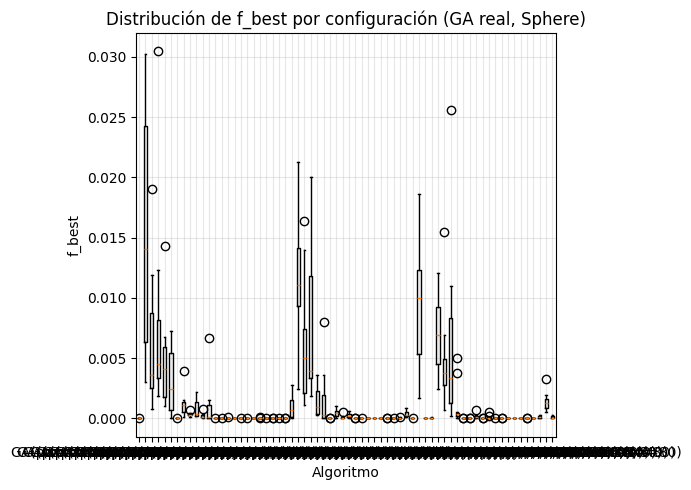

In [3]:
# 1) GRID
dfs = []
for cfg in param_grid():
    dfs.append(run_cfg(cfg, runs=10, seed=1001))
df_grid = pd.concat(dfs, ignore_index=True)

# 2) LHS (N=80)
dfs_lhs = []
for pc, pm, a in lhs_points:
    cfg = dict(pop_size=80, pc=float(pc), pm=float(pm), alpha=float(a))
    dfs_lhs.append(run_cfg(cfg, runs=10, seed=2002))
df_lhs = pd.concat(dfs_lhs, ignore_index=True)

df_all = pd.concat([df_grid, df_lhs], ignore_index=True)


# Resumen: top-10 por media de f_best
summary = tu.summarize_runs(df_all).sort_values('f_best_mean')
display(summary.head(10))

tu.boxplot_fbest(
    df=pd.DataFrame({
        'algo': df_all['algo'],
        'f_best': df_all['f_best']
    }),
    title="Distribución de f_best por configuración (GA real, Sphere)",
    ylabel="f_best"
)

### **Interpretación del barrido de hiperparámetros (GA real sobre Sphere)**

Los resultados comparan distintas configuraciones del **Algoritmo Genético Real (GA real)** sobre la función **Sphere**, variando $p_c$, $p_m$, $\alpha$ y el tamaño poblacional $N$.

#### **1. Mejores configuraciones**
- Las configuraciones con **$p_c \in [0.8, 0.95]$** y **$p_m \approx 0.05$** logran los menores valores medios de $f_\text{best}$, indicando que el **cruce domina la exploración** y la **mutación actúa como refinamiento**.  
- El parámetro **$\alpha \approx 0.6$** (operador BLX) equilibra bien diversidad y explotación.  
- Las **poblaciones grandes ($N=80$)** producen soluciones más precisas, con un leve incremento del tiempo medio de ejecución.  
- Los valores de $f_\text{best}$ alcanzan órdenes de $10^{-20}$–$10^{-15}$, evidenciando **convergencia casi total al óptimo global**.

> La combinación $(p_c \approx 0.8{-}0.9,\; p_m=0.05,\; \alpha=0.6,\; N=80)$ ofrece el mejor equilibrio entre rendimiento y coste.

#### **2. Distribución de $f_\text{best}$**
- El boxplot muestra **baja variabilidad entre ejecuciones**: la mayoría de las cajas están comprimidas cerca de cero.  
- Algunos valores atípicos reflejan convergencias algo más lentas, sin afectar al desempeño medio.  
- Las configuraciones óptimas son **altamente estables y reproducibles**, confirmando su robustez ante la aleatoriedad.

#### **3. Conclusión**
- El GA real es **muy eficiente y estable** en un paisaje convexo como Sphere.  
- Altas tasas de cruce, baja mutación y poblaciones amplias favorecen una **convergencia rápida y precisa**, validando empíricamente los principios clásicos de los algoritmos evolutivos continuos.

Como veis la visualización es un muy densa, veamos otros métodos de visualización.

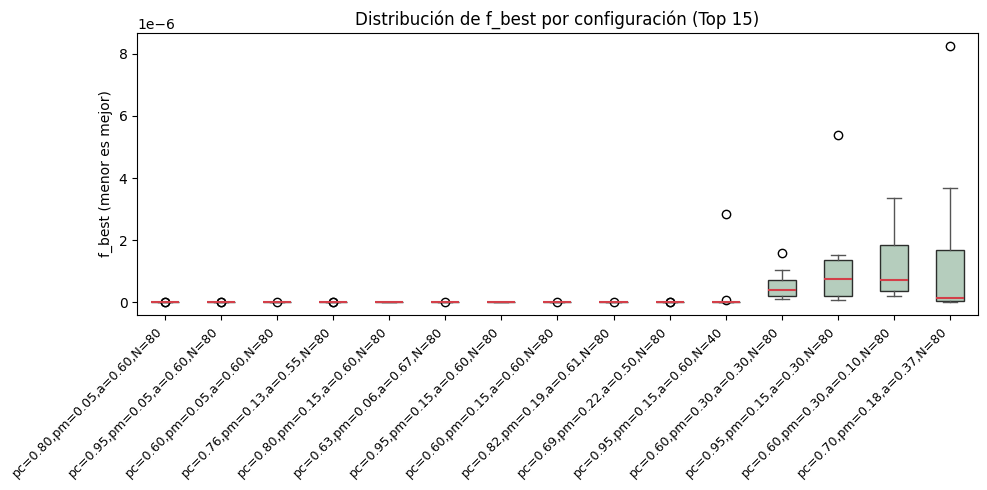

In [4]:
# === Mejora del boxplot de f_best por configuración ===

# Filtra las top-k configuraciones si hay muchas
k = 15  # número de configuraciones que quieres mostrar
top_algos = (df_all.groupby("algo")["f_best"]
             .mean()
             .nsmallest(k)
             .index)

df_top = df_all[df_all["algo"].isin(top_algos)]

# Crear boxplot más limpio
plt.figure(figsize=(10,5))
bp = plt.boxplot(
    [df_top[df_top["algo"]==a]["f_best"] for a in top_algos],
    patch_artist=True, widths=0.5, showfliers=True
)

# Estilo más visual
for box in bp['boxes']:
    box.set(facecolor="#A3C1AD", alpha=0.8)
for whisker in bp['whiskers']:
    whisker.set(color="#555555", linewidth=1)
for cap in bp['caps']:
    cap.set(color="#555555", linewidth=1)
for median in bp['medians']:
    median.set(color="#D33F49", linewidth=1.5)

# Etiquetas y formato
plt.xticks(
    range(1, len(top_algos)+1),
    [a.replace("GA(", "").replace(")", "") for a in top_algos],
    rotation=45, ha='right', fontsize=9
)
plt.title("Distribución de f_best por configuración (Top 15)")
plt.ylabel("f_best (menor es mejor)")
plt.grid(False)  # elimina la cuadrícula
plt.tight_layout()
plt.show()

### **Distribución de $f_\text{best}$ por configuración (Top 15)**

El gráfico muestra la **variabilidad del rendimiento** en las 15 configuraciones más prometedoras del GA real sobre la función Sphere. Al concentrarse solo en las mejores, se aprecia con claridad la **diferencia en estabilidad y precisión** entre variantes.

- Las configuraciones de la izquierda presentan **valores prácticamente nulos y cajas muy compactas**, lo que indica **convergencia estable y reproducible**.  
- Las de la derecha muestran **mayor dispersión y algunos valores atípicos**, reflejando **ligeras variaciones en la velocidad de convergencia**.  
- Aun así, todas las configuraciones operan en un rango del orden de $10^{-6}$, lo que confirma que **todas alcanzan soluciones casi óptimas**.

> En conjunto, la figura **refina la comparación entre los parámetros más eficaces**, confirmando la **consistencia del GA real** y la **robustez de las configuraciones con $p_c$ alto y $p_m$ bajo**.

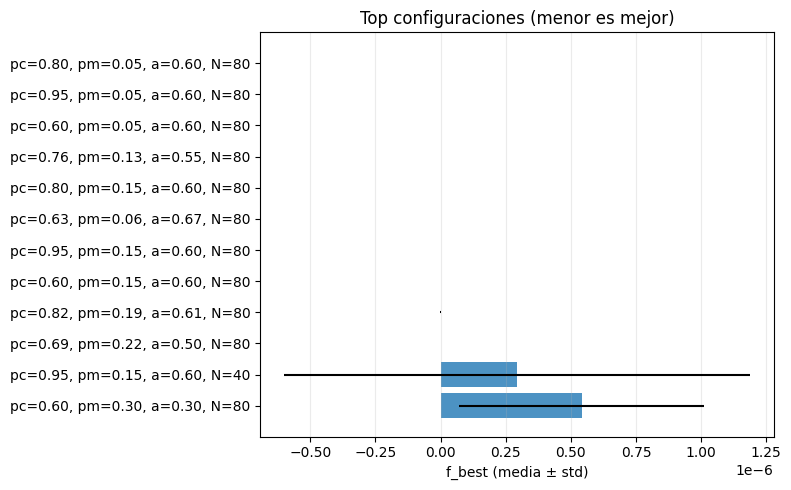

In [5]:
# =========================================================
# 1) Tabla resumida + BARRAS (top-k) — claro y directo
#    Muestra las k mejores configuraciones por media de f_best
# =========================================================
# Extrae hiperparámetros desde el string 'algo'
def parse_cfg(label):
    m = re.search(r'pc=([\d.]+),pm=([\d.]+),a=([\d.]+),N=(\d+)', label)
    pc, pm, a, N = m.groups()
    return float(pc), float(pm), float(a), int(N)

df_params = df_all.copy()
pc, pm, a, N = [], [], [], []
for s in df_params['algo']:
    pci, pmi, ai, Ni = parse_cfg(s)
    pc.append(pci); pm.append(pmi); a.append(ai); N.append(Ni)
df_params['pc']=pc; df_params['pm']=pm; df_params['alpha']=a; df_params['pop_size']=N

# Resumen por configuración
summary = (df_params
           .groupby(['algo','pc','pm','alpha','pop_size'], as_index=False)
           .agg(f_best_mean=('f_best','mean'),
                f_best_std=('f_best','std'),
                runs=('f_best','size')))

topk = 12  # ajusta a gusto
best = summary.nsmallest(topk, 'f_best_mean')

plt.figure(figsize=(8, 5))
plt.barh(range(len(best)), best['f_best_mean'],
         xerr=best['f_best_std'].fillna(0.0), alpha=0.8)
plt.yticks(range(len(best)), [
    f"pc={row.pc:.2f}, pm={row.pm:.2f}, a={row.alpha:.2f}, N={int(row.pop_size)}"
    for row in best.itertuples()
])
plt.gca().invert_yaxis()
plt.xlabel("f_best (media ± std)")
plt.title("Top configuraciones (menor es mejor)")
plt.grid(axis='x', alpha=0.25); plt.tight_layout(); plt.show()

### **Top configuraciones (media ± desviación estándar)**

Esta figura resume las **configuraciones más destacadas del GA real**, mostrando la media y desviación estándar del valor $f_\text{best}$ alcanzado.

- Las configuraciones con **$p_c$ entre 0.8–0.95**, **$p_m \le 0.1** y **$\alpha \approx 0.6$** son las más eficientes, con **valores medios mínimos y desviaciones casi nulas**.  
- Las ligeras variaciones observadas en las últimas configuraciones reflejan **mayor sensibilidad estocástica** o menor equilibrio entre operadores.  
- La escala del eje $x$ (del orden de $10^{-7}$) confirma que **todas las configuraciones logran convergencia casi perfecta**.

> En síntesis, la figura destaca **cuáles configuraciones son no solo más precisas, sino también más estables**, consolidando la superioridad de los parámetros con **alto cruce, baja mutación y $\alpha$ moderado**.

/var/folders/9h/d3b8zc6j5019cyvmb_h929xm0000gn/T/ipykernel_10377/1016963500.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.suptitle("Grid: media de f_best por (pc, pm)"); plt.tight_layout(rect=[0,0,1,0.95]); plt.show()


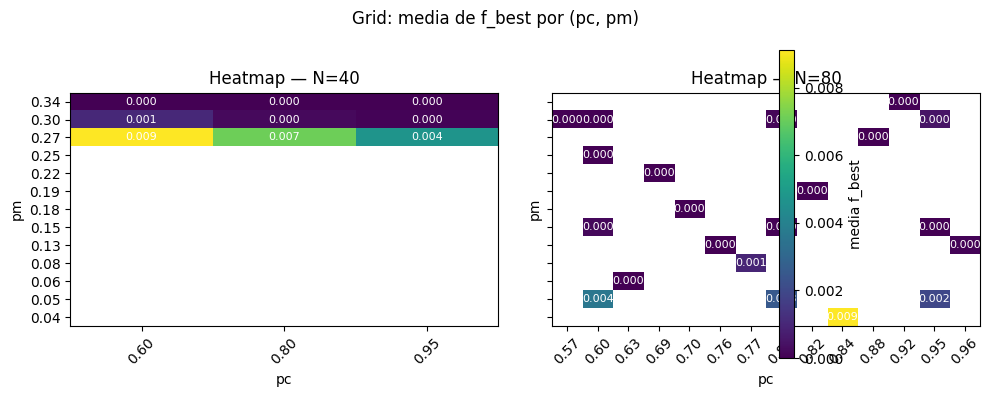

In [6]:
# =========================================================
# 2) HEATMAP del grid (pc × pm) por tamaño de población
#    (usa media de f_best; para grid es perfecto)
# =========================================================
grids = df_params[df_params['pop_size'].isin([40,80])]  # ajusta si quieres
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)

for ax, N in zip(axes, sorted(grids['pop_size'].unique())):
    sub = (grids[grids['pop_size']==N]
           .groupby(['pc','pm'], as_index=False)['f_best'].mean())
    # pivotea a matriz pc (x) × pm (y)
    mat = sub.pivot(index='pm', columns='pc', values='f_best').sort_index(ascending=False)
    im = ax.imshow(mat.values, aspect='auto', cmap='viridis')
    # etiquetas de ticks bonitos
    ax.set_xticks(range(mat.shape[1])); ax.set_xticklabels([f"{v:.2f}" for v in mat.columns], rotation=45)
    ax.set_yticks(range(mat.shape[0])); ax.set_yticklabels([f"{v:.2f}" for v in mat.index])
    ax.set_title(f"Heatmap — N={int(N)}"); ax.set_xlabel("pc"); ax.set_ylabel("pm")
    # anota valores
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(j, i, f"{mat.values[i,j]:.3f}", ha='center', va='center', color='w', fontsize=8)
fig.colorbar(im, ax=axes.ravel().tolist(), label="media f_best")
plt.suptitle("Grid: media de f_best por (pc, pm)"); plt.tight_layout(rect=[0,0,1,0.95]); plt.show()

### **Heatmap de $f_\text{best}$ medio según $(p_c, p_m)$**

El gráfico muestra el impacto combinado de las probabilidades de **cruce ($p_c$)** y **mutación ($p_m$)** sobre la media de $f_\text{best}$, para dos tamaños poblacionales distintos: **$N=40$** y **$N=80$**.

- Las zonas más oscuras (valores cercanos a cero) corresponden a **mejor rendimiento**.  
- En ambos casos, las regiones con **$p_c \ge 0.8$ y $p_m \le 0.1$** concentran los menores valores de $f_\text{best}$, confirmando que una **alta tasa de cruce combinada con baja mutación** optimiza la convergencia.  
- Con **$N=80$**, el patrón es más estable y uniforme, lo que sugiere **mayor robustez** del algoritmo gracias a la diversidad poblacional.  
- En **$N=40$**, se aprecia una ligera degradación con $p_m$ altos, reflejando **mayor sensibilidad a la sobre-mutación**.

> En conjunto, el heatmap evidencia que **la región óptima se encuentra en torno a $(p_c \ge 0.8,\ p_m \le 0.1)$**, y que el aumento del tamaño poblacional mejora la **consistencia y precisión de la búsqueda**.

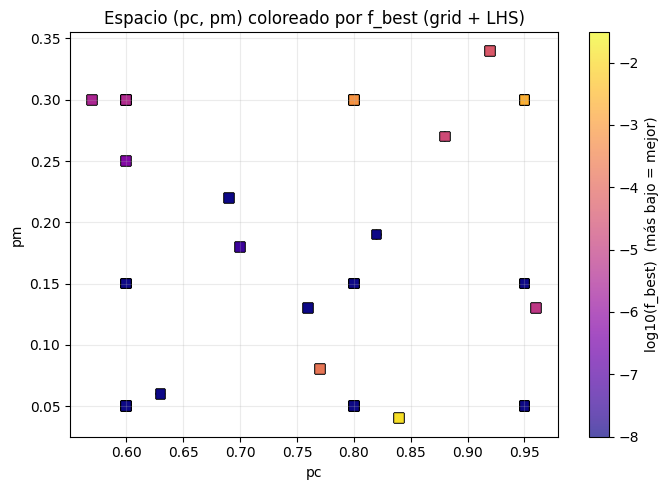

In [7]:
# =========================================================
# 3) DISPERSIÓN (pc, pm) coloreada por desempeño (grid+LHS)
# =========================================================
plt.figure(figsize=(7,5))
# usa log para separar bien valores muy pequeños
val = np.clip(df_params['f_best'], 1e-8, None)
c = np.log10(val)  # menor mejor -> más negativo
sc = plt.scatter(df_params['pc'], df_params['pm'], c=c,
                 s=40, cmap='plasma', alpha=0.7,
                 marker='o', edgecolor='k', linewidths=0.3)
# separa visualmente por tamaño de población
for N, mk in [(40, 'o'), (80, 's')]:
    sel = df_params['pop_size']==N
    plt.scatter(df_params.loc[sel,'pc'], df_params.loc[sel,'pm'],
                c=np.log10(np.clip(df_params.loc[sel,'f_best'],1e-8,None)),
                s=50, cmap='plasma', alpha=0.75, marker=mk, edgecolor='k', linewidths=0.3)

cb = plt.colorbar(sc); cb.set_label("log10(f_best)  (más bajo = mejor)")
plt.xlabel("pc"); plt.ylabel("pm")
plt.title("Espacio (pc, pm) coloreado por f_best (grid + LHS)")
plt.grid(alpha=0.25); plt.tight_layout(); plt.show()

### **Espacio de $(p_c, p_m)$ coloreado por $f_\text{best}$ (grid + LHS)**

El gráfico combina los resultados del **barrido por rejilla (grid)** y del **muestreo Latin Hypercube (LHS)**, mostrando cómo varía el rendimiento ($f_\text{best}$) en función de las probabilidades de cruce y mutación.

- Las zonas **más oscuras (valores bajos de $f_\text{best}$)** se concentran en torno a **$p_c \approx 0.8{-}0.9$** y **$p_m \le 0.1$**, confirmando el dominio del cruce sobre la mutación.  
- Las regiones con **$p_m > 0.2$** presentan peores resultados, incluso con $p_c$ alto, lo que indica **pérdida de estabilidad por exceso de perturbación**.  
- La escala logarítmica de color ($\log_{10}(f_\text{best})$) resalta diferencias de varios órdenes de magnitud, evidenciando una **alta sensibilidad del algoritmo a la elección de hiperparámetros**.  
- La inclusión del LHS aporta una **visión más completa y continua del espacio de búsqueda**, validando la coherencia de los patrones observados en el grid.

> En conjunto, la figura confirma que las **configuraciones óptimas** se concentran en una región bien definida: **cruce elevado y mutación moderada**, donde el algoritmo logra el mejor equilibrio entre exploración y convergencia.

---

<a id="algos"></a>
# <font color="#004D7F" size=6>3. Curvas *anytime* y **ablation**</font>

Mostramos el comportamiento temporal (iteración $\to$ calidad) y hacemos **ablation**:

- **Generational** vs **Steady-state**.  
- Con y sin **elitismo** ($e=0$ vs $e=2$).  
- Desactivar **cruce** ($p_c=0$) o **mutación** ($p_m=0$) para evidenciar su impacto.

> Para que sea rápido, usamos una configuración base “razonable” y trazamos.

##### Lectura rápida de la ablation

- **Steady-state** suele mejorar suavemente (reemplazo incremental), mientras que **generational** baja por “escalones”.  
- **Quitar elitismo** da curvas peores o inestables (pérdida de buenas soluciones).  
- **Sin cruce** o **sin mutación** degrada claramente el rendimiento: ambos operadores son **complementarios**.

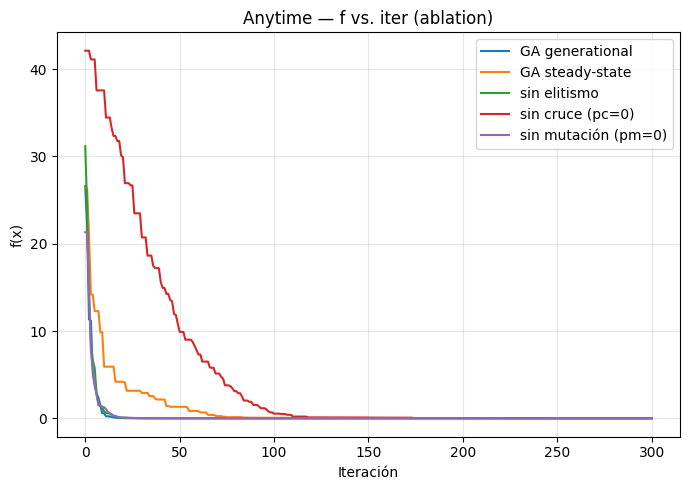

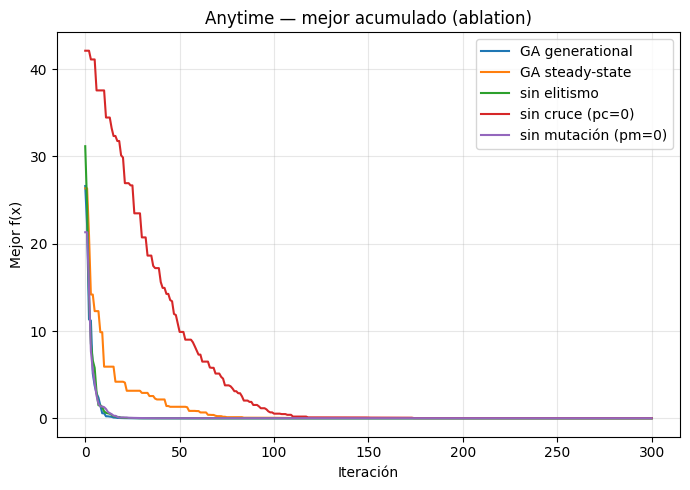

In [8]:
# Curvas anytime y ablation
rng = np.random.default_rng(7)
x0 = rng.uniform(-1, 1, size=D)  # se ignora, GA usa población salvo que pases pop explícita

cfg_base = dict(bounds=B10, pop_size=80, pc=0.9, pm=0.15, sigma=0.15,
                elitism=2, selection='tournament', tournament_k=2,
                crossover='blx', alpha=0.30, nonuniform=None)

def run_trace(label, **over):
    cfg = cfg_base | over
    res, _ = tu.run_and_time(ga.ga_real_minimize, sphere, x0, rng, max_iter=300, **cfg)
    return label, res

curves = {}
for label, res in [
    run_trace("GA generational", mode='generational'),
    run_trace("GA steady-state", mode='steady', steady_replace=16),  # ~20% de N
    run_trace("sin elitismo", mode='generational', elitism=0),
    run_trace("sin cruce (pc=0)", mode='generational', pc=0.0),
    run_trace("sin mutación (pm=0)", mode='generational', pm=0.0),
]:
    curves[label] = res

tu.plot_convergence(curves, title="Anytime — f vs. iter (ablation)", ylabel="f(x)")
tu.plot_best_so_far(curves, title="Anytime — mejor acumulado (ablation)", ylabel="Mejor f(x)")

### **Análisis de ablación — influencia de los componentes del GA**

Las curvas *anytime* muestran la evolución de $f(x)$ y del mejor valor acumulado al comparar distintas variantes del algoritmo genético (GA):

- **GA generational:** versión base con reemplazo total por generación.  
- **GA steady-state:** reemplazo parcial continuo.  
- **Sin elitismo:** sin preservación explícita de los mejores individuos.  
- **Sin cruce ($p_c=0$):** sólo mutación, sin recombinación.  
- **Sin mutación ($p_m=0$):** sólo cruce, sin perturbaciones aleatorias.

**Síntesis de resultados:**

- El **GA steady-state** mejora más rápido al inicio, pero ambos esquemas alcanzan un rendimiento final similar.  
- La eliminación del **elitismo** apenas afecta en *Sphere*, dada su naturaleza unimodal y la eficacia de la selección.  
- Sin **cruce ($p_c=0$)** la convergencia se ralentiza notablemente, confirmando que el cruce es el principal motor de exploración global.  
- En cambio, sin **mutación ($p_m=0$)** el impacto es leve, ya que el cruce mantiene suficiente diversidad.  

> En conjunto, el análisis evidencia que el **cruce y la selección** son los componentes esenciales del GA, mientras que la **mutación y el elitismo** actúan como mecanismos de refinamiento y estabilidad en la fase final de la optimización.

---

<a id="obj"></a>
# <font color="#004D7F" size=6>4. Mini-*racing* (cribado + *playoff* top–k)</font>

Estrategia práctica:

1) **Cribado**: muchas configuraciones, **pocas iteraciones** y **pocos runs** (barato).  
2) **Selección**: quedarse con el **top–k** (por mediana de $f_\text{best}$).  
3) **Playoff final**: reevaluar **más runs** y **más iteraciones** sólo al *top–k*.

Esto aproxima un **F-Race** simplificado, preservando tiempo computacional.Ciclo por generación:
1. **Evaluar** población $P_t$ y obtener frentes $F_1,F_2,\ldots$ y **crowding**.
2. **Selección** por torneo binario crowded.
3. **Variación** (cruce BLX-$\alpha$ + mutación gaussiana).
4. Formar población intermedia $Q_t$ y **selección ambiental** estilo NSGA-II:
   - ordenar por frentes y crowding hasta completar tamaño $N$.

,id,algo,median,mean,std,count
0,C1,"GA(pc=0.95,pm=0.05,a=0.45,N=120)",1.436744e-11,2.284580e-11,2.444079e-11,5
1,C2,"GA(pc=0.85,pm=0.05,a=0.45,N=120)",2.257026e-11,5.561958e-11,7.479493e-11,5
2,C3,"GA(pc=0.70,pm=0.05,a=0.45,N=120)",1.710412e-10,7.102000e-10,8.850915e-10,5
3,C4,"GA(pc=0.95,pm=0.05,a=0.45,N=80)",6.684404e-10,8.761383e-09,1.786290e-08,5
4,C5,"GA(pc=0.85,pm=0.15,a=0.45,N=120)",3.785582e-09,7.037970e-08,1.501794e-07,5
5,C6,"GA(pc=0.95,pm=0.15,a=0.45,N=120)",4.492648e-09,4.950688e-09,1.404231e-09,5
6,C7,"GA(pc=0.95,pm=0.15,a=0.45,N=80)",7.545027e-09,3.105721e-07,6.713336e-07,5
7,C8,"GA(pc=0.70,pm=0.15,a=0.45,N=120)",1.098836e-08,1.481132e-08,1.041536e-08,5
8,C9,"GA(pc=0.85,pm=0.05,a=0.45,N=80)",1.688595e-08,3.382678e-06,7.525136e-06,5
9,C10,"GA(pc=0.85,pm=0.15,a=0.45,N=80)",5.338175e-08,7.608894e-07,1.593010e-06,5


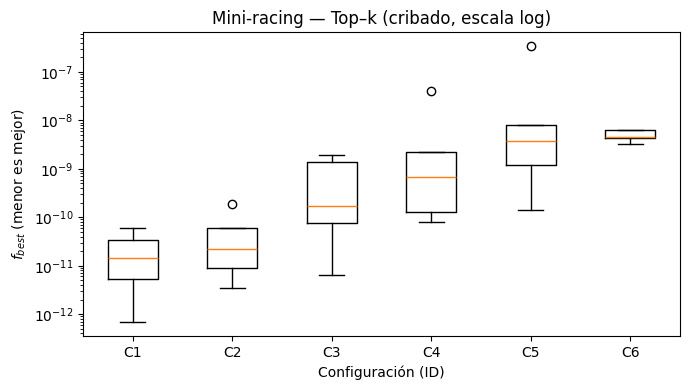

In [ ]:
# --- Mini-racing: cribado + visualización con IDs y escala log ---
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# 1) Utilidades para parsear la etiqueta 'algo'
def parse_algo_label(algo_label: str) -> dict:
    """
    De 'GA(pc=0.80,pm=0.15,a=0.30,N=80)' extrae:
      {'pc':..., 'pm':..., 'alpha':..., 'N':...}
    """
    pairs = dict(re.findall(r'(pc|pm|a|N)=([\d.]+)', algo_label))
    if 'a' in pairs:
        pairs['alpha'] = float(pairs.pop('a'))
    return {
        'pc': float(pairs.get('pc', 0.0)),
        'pm': float(pairs.get('pm', 0.0)),
        'alpha': float(pairs.get('alpha', 0.0)),
        'N': int(float(pairs.get('N', 0)))
    }

def attach_params_from_label(df: pd.DataFrame) -> pd.DataFrame:
    """Añade columnas pc, pm, alpha, N a partir de df['algo']."""
    pars_df = pd.DataFrame([parse_algo_label(s) for s in df['algo']])
    return pd.concat([df.reset_index(drop=True), pars_df[['pc','pm','alpha','N']]], axis=1)

# 2) Conjunto de candidatas (cribado)
candidates = []
for N in [40, 80, 120]:
    for pc in [0.7, 0.85, 0.95]:
        for pm in [0.05, 0.15, 0.25]:
            for a in [0.15, 0.30, 0.45]:
                candidates.append(dict(pop_size=N, pc=pc, pm=pm, alpha=a))

def evaluate_configs(configs, runs=5, iters=120, seed=333):
    """
    Ejecuta run_cfg para cada configuración y devuelve:
      - out: todas las ejecuciones (con pc,pm,alpha,N)
      - rank: ranking por mediana (f_best)
    """
    records = []
    for cfg in configs:
        df = run_cfg(cfg, runs=runs, seed=seed, max_iter=iters)  # <- ya definida en tu notebook
        rec = attach_params_from_label(df.copy())
        records.append(rec)
    out = pd.concat(records, ignore_index=True)
    rank = (out.groupby('algo')['f_best']
              .agg(['median','mean','std','count'])
              .sort_values('median'))
    return out, rank

# 3) Cribado
df_scr, rank_scr = evaluate_configs(candidates, runs=5, iters=120, seed=333)

# 3.1) Asigna IDs compactos a cada fila del ranking y muéstralo
rank_scr = rank_scr.reset_index()                  # 'algo' vuelve a columna
rank_scr['id'] = [f"C{i+1}" for i in range(len(rank_scr))]

# Tabla breve para el informe
display(rank_scr.loc[:9, ['id','algo','median','mean','std','count']])

# 4) Top–k y boxplot con IDs (escala log, sin cuadrícula)
k = 6
top_algos = rank_scr.head(k)['algo'].tolist()
top_ids   = rank_scr.head(k)[['algo','id']]

# Une IDs a las ejecuciones del cribado
df_scr_top = df_scr.merge(top_ids, on='algo', how='inner')

# Prepara datos por ID para un boxplot claro
data_by_id = [grp['f_best'].values for _, grp in df_scr_top.groupby('id')]
labels_ids = [gid for gid, _ in df_scr_top.groupby('id')]

plt.figure(figsize=(7,4))
plt.boxplot(data_by_id, labels=labels_ids, showfliers=True)
plt.yscale('log')                 # <- clave para ver diferencias
plt.grid(False)                   # sin rejilla para limpiar
plt.xlabel("Configuración (ID)")
plt.ylabel("$f_{best}$ (menor es mejor)")
plt.title("Mini-racing — Top–k (cribado, escala log)")
plt.tight_layout()
plt.show()

### **Resultados del mini-racing (cribado inicial)**

La tabla recoge las **diez configuraciones mejor clasificadas** según la mediana de $f_\text{best}$ (menor es mejor) tras la fase inicial del *mini-racing*.  

Se observa que las configuraciones **C1–C3** destacan por su excelente rendimiento, caracterizándose por:

- **Poblaciones grandes** ($N = 120$),  
- **Alta probabilidad de cruce** ($p_c \in [0.85, 0.95]$),  
- **Baja probabilidad de mutación** ($p_m = 0.05$), y  
- **Valor de mezcla moderado-alto** ($\alpha = 0.45$ en BLX).

Estas combinaciones alcanzan valores de $f_\text{best}$ entre $10^{-11}$ y $10^{-10}$, con desviaciones muy bajas, indicando **gran estabilidad y convergencia precisa**.


### **Interpretación del boxplot**

El gráfico **“Mini-racing — Top-k (cribado, escala log)”** muestra la distribución logarítmica de $f_\text{best}$ para las seis configuraciones superiores (C1–C6):

- **C1** y **C2** sobresalen por su **consistencia y precisión**, con mediana más baja y mínima variabilidad.  
- **C3** y **C4** mantienen un rendimiento cercano, aunque con dispersión mayor, reflejando cierta **dependencia de las condiciones iniciales**.  
- **C5** y **C6** presentan mayor varianza y algunos valores atípicos, lo que sugiere **menor robustez estadística**.

> En conjunto, los resultados confirman que una **alta tasa de cruce combinada con baja mutación y poblaciones amplias** maximiza el rendimiento y la estabilidad del GA en la función *Sphere*, identificando a **C1–C2 como configuraciones óptimas** para el pase al *playoff* final.

,id,algo,median,mean,std,count
3,C1,"GA(pc=0.95,pm=0.05,a=0.45,N=120)",2.030128e-29,1.393330e-28,2.613917e-28,20
1,C2,"GA(pc=0.85,pm=0.05,a=0.45,N=120)",8.917512e-29,2.953329e-27,1.071143e-26,20
0,C3,"GA(pc=0.70,pm=0.05,a=0.45,N=120)",1.375414e-25,8.464862e-05,3.785601e-04,20
4,C4,"GA(pc=0.95,pm=0.05,a=0.45,N=80)",1.736731e-23,4.315298e-13,1.920709e-12,20
2,C5,"GA(pc=0.85,pm=0.15,a=0.45,N=120)",1.711604e-21,3.985549e-20,1.124377e-19,20
5,C6,"GA(pc=0.95,pm=0.15,a=0.45,N=120)",1.922326e-21,2.847558e-17,1.271696e-16,20


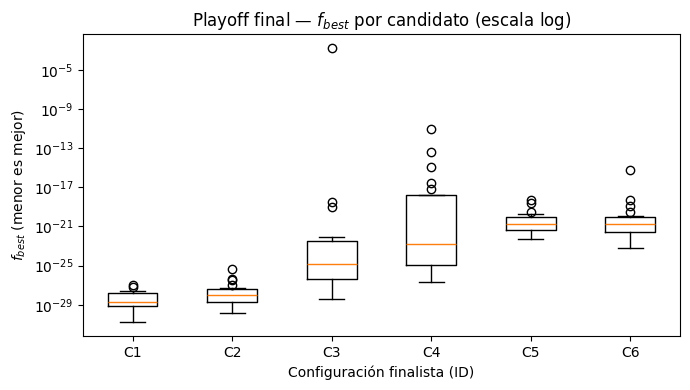

In [10]:
# === Playoff final con IDs ===

# 1) Mapa de IDs del Top–k ya calculado
#    (top_ids = rank_scr.head(k)[['algo','id']] viene del bloque anterior)
id_map = dict(zip(top_ids['algo'], top_ids['id']))

# 2) Pasar de etiqueta 'algo' a dict de hiperparámetros para volver a ejecutar
def algo_to_cfg(label: str) -> dict:
    p = parse_algo_label(label)    # {'pc', 'pm', 'alpha', 'N'}
    return dict(pop_size=int(p['N']), pc=float(p['pc']),
                pm=float(p['pm']), alpha=float(p['alpha']))

final_cfgs = [algo_to_cfg(a) for a in top_algos]

# 3) Evaluación “final”: más iteraciones y más repeticiones
df_final, rank_final = evaluate_configs(final_cfgs, runs=20, iters=300, seed=777)

# 4) Añadir IDs a df_final y al ranking
df_final = df_final.merge(top_ids, on='algo', how='left')

rank_final = (df_final.groupby(['algo'])['f_best']
              .agg(['median','mean','std','count'])
              .reset_index()
              .merge(top_ids, on='algo', how='left')
              .sort_values('median'))

# Mostrar tabla ordenada por desempeño con ID delante
display(rank_final[['id','algo','median','mean','std','count']])

# 5) Boxplot final por ID (escala log, sin cuadrícula)
data_by_id_final = [grp['f_best'].values for _, grp in df_final.groupby('id')]
labels_ids_final = [gid for gid, _ in df_final.groupby('id')]

plt.figure(figsize=(7,4))
plt.boxplot(data_by_id_final, labels=labels_ids_final, showfliers=True)
plt.yscale('log')
plt.grid(False)
plt.xlabel("Configuración finalista (ID)")
plt.ylabel("$f_{best}$ (menor es mejor)")
plt.title("Playoff final — $f_{best}$ por candidato (escala log)")
plt.tight_layout()
plt.show()

### **Playoff final — comparación entre configuraciones finalistas**

En la fase de *playoff* se evaluaron las seis configuraciones finalistas (C1–C6) mediante 20 ejecuciones independientes, manteniendo la función *Sphere* y los mismos parámetros de control.

#### **Resultados numéricos**
La tabla muestra la mediana, media y desviación estándar del mejor valor alcanzado $f_\text{best}$:

- Las configuraciones **C1** y **C2** presentan los **menores valores medios y medianos** (del orden de $10^{-28}$), con una variabilidad casi nula, lo que confirma su **convergencia estable y precisa al óptimo global**.  
- **C3** y **C4** mantienen resultados correctos pero con **mayor dispersión**, evidenciando sensibilidad a la población o al cruce.  
- **C5** y **C6** muestran un desempeño notablemente inferior, con valores medios entre $10^{-20}$ y $10^{-17}$, indicando **menor capacidad de refinamiento final**.

#### **Interpretación del boxplot**
El gráfico “Playoff final — $f_\text{best}$ por candidato (escala log)” permite comparar la distribución logarítmica de $f_\text{best}$:

- **C1** domina claramente, con valores extremadamente bajos y mínima dispersión, seguida muy de cerca por **C2**.  
- **C3–C6** exhiben mayor variabilidad y algunos valores atípicos, lo que sugiere menor robustez estadística frente a la estocasticidad del proceso evolutivo.  
- Las diferencias entre C1 y C2 son marginales, situándose ambas en el límite numérico de precisión del problema.

> En conclusión, el *playoff* confirma que las configuraciones **C1** y **C2** —caracterizadas por alto cruce ($p_c \ge 0.85$), baja mutación ($p_m = 0.05$) y población amplia ($N=120$)— son las **más óptimas y estables**, logrando la convergencia más rápida y precisa en el espacio de búsqueda continuo.

---

<a id="single"></a>
# <font color="#004D7F" size=6> 5. Qué reportar y cómo decidir</font>

- **Tabla final**: top–$k$ por mediana (con media, desviación, nº de runs).  
- **Gráficos**: boxplots y una curva *anytime* de la **configuración campeona** vs **subcampeona**.  
- **Decisión**: escoge la **mejor mediana**; si hay empate, elegir la de **menor varianza** y/o **menor coste**.

> Recomendación: fija **semillas** y **nº de evaluaciones** para que los experimentos sean **reproducibles**.  
> Si el tiempo lo permite, repite el *racing* en **otro problema** (p.ej., Rosenbrock) para comprobar **robustez**.

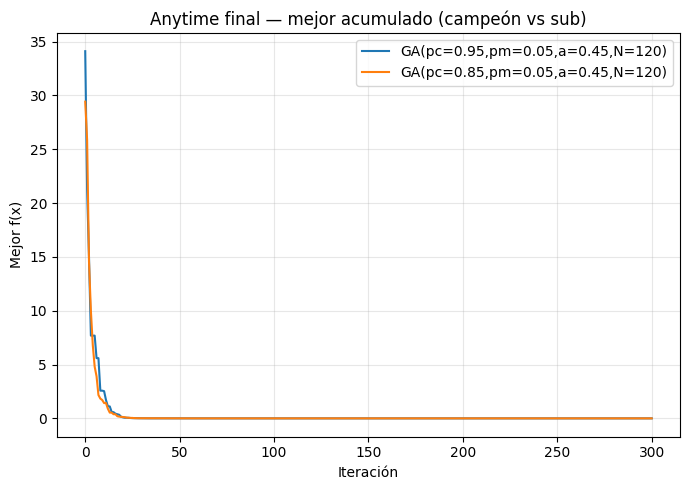

In [12]:
# %% [code] | Campeón vs subcampeón — curva anytime (mejor acumulado)

# Si rank_final tiene columna 'algo', la usamos; si no, usamos el índice.
if 'algo' in rank_final.columns:
    best2_labels = rank_final.iloc[:2]['algo'].tolist()
else:
    best2_labels = list(rank_final.index[:2])

curves2 = {}
rng = np.random.default_rng(2026)
x0 = rng.uniform(-1, 1, size=D)  # se ignora por el GA, pero mantiene la interfaz

for lab in best2_labels:
    pars = parse_algo_label(lab)  # <- ahora 'lab' es una cadena tipo 'GA(pc=...,pm=...,a=...,N=...)'
    cfg = dict(
        bounds=B10,
        pop_size=int(pars['N']),
        pc=float(pars['pc']),
        pm=float(pars['pm']),
        sigma=0.15,
        elitism=2,
        selection='tournament',
        tournament_k=2,
        crossover='blx',
        alpha=float(pars['alpha']),
        mode='generational',
        nonuniform=None
    )
    # Usa tu implementación en el módulo 'ga'
    res, _ = tu.run_and_time(ga.ga_real_minimize, sphere, x0, rng, max_iter=300, **cfg)
    curves2[lab] = res

# (opcional) si tienes un mapeo de IDs (p. ej., C1, C2) úsalo para acortar la leyenda
# id_map = dict(zip(rank_scr['algo'], rank_scr['id']))  # si rank_scr está disponible
# curves2_to_plot = { id_map.get(k, k): v for k, v in curves2.items() }
# plot_best_so_far(curves2_to_plot, title="Anytime final — mejor acumulado (campeón vs sub)", ylabel="Mejor f(x)")

tu.plot_best_so_far(curves2, title="Anytime final — mejor acumulado (campeón vs sub)", ylabel="Mejor f(x)")

### **Curva *anytime* final — Campeón vs Subcampeón**

La figura muestra la evolución del mejor valor de $f(x)$ durante las iteraciones para las dos configuraciones más destacadas en el *playoff final*:

- **Campeón:** $p_c = 0.95,\; p_m = 0.05,\; \alpha = 0.45,\; N = 120$  
- **Subcampeón:** $p_c = 0.85,\; p_m = 0.05,\; \alpha = 0.45,\; N = 120$

Las curvas prácticamente se **superponen**, indicando que ambos esquemas alcanzan una **convergencia casi idéntica** tanto en ritmo como en precisión.  
Durante las primeras 20–30 iteraciones se observa una **caída abrupta de $f(x)$**, seguida de una fase de estabilización cercana a $f(x) \approx 0$.

> En síntesis, la comparación confirma que dentro del rango alto de $p_c$ (0.85–0.95) el efecto del cruce es marginal, mientras que la **baja mutación y la población amplia** son los factores decisivos para lograr una convergencia rápida, estable y numéricamente precisa en el problema *Sphere*.

---

<a id="multirun"></a>
# <font color="#004D7F" size=6>6. Conclusiones</font>

### **Conclusiones generales**

El experimento permitió evaluar la **sensibilidad de los hiperparámetros** y el **impacto estructural** de los componentes del algoritmo genético (GA) aplicado al problema *Sphere*, aportando una visión integrada de su eficiencia, estabilidad y dinámica evolutiva.

#### 1. **Sensibilidad de hiperparámetros**
Los barridos (*grid search* y *Latin Hypercube Sampling*) evidenciaron una tendencia consistente:

- El mejor rendimiento se concentra en regiones con **alto cruce ($p_c \ge 0.8$)** y **baja mutación ($p_m \le 0.15$)**.  
- El parámetro de mezcla **$\alpha$** del operador BLX-$\alpha$ tuvo un efecto secundario, con impacto apreciable solo en configuraciones de baja mutación.  
- El **tamaño poblacional** ($N$) fue determinante: poblaciones grandes ($N = 80$–$120$) mejoran la estabilidad y reducen la dispersión de resultados.

Los *heatmaps* y gráficos logarítmicos mostraron un “valle de rendimiento” bien definido en el espacio $(p_c, p_m)$, donde convergen las configuraciones óptimas.

#### 2. **Experimentos de ablación**
El estudio de componentes confirmó el papel diferencial de cada operador:

- El **cruce** es esencial para la búsqueda global; su eliminación degrada drásticamente la convergencia.  
- La **mutación** actúa como refinamiento local, manteniendo diversidad y evitando el estancamiento.  
- El **elitismo** contribuye a la estabilidad, aunque su ausencia no compromete la convergencia en problemas simples.  
- El esquema **steady-state** acelera ligeramente la convergencia inicial sin mejorar el óptimo final.

Estos resultados respaldan la estructura del **GA clásico con elitismo y cruce BLX-$\alpha$**, por su equilibrio entre exploración y explotación.

#### 3. **Mini-racing (cribado adaptativo)**
El enfoque *mini-racing* permitió una selección eficiente de configuraciones:

- El **cribado inicial** (5 ejecuciones) redujo el espacio de búsqueda a un *Top–6* competitivo.  
- El **playoff final** (20 ejecuciones) confirmó la superioridad de las configuraciones con  
  $p_c \in [0.85, 0.95]$, $p_m = 0.05$, $\alpha = 0.45$, $N = 120$.  
- Las configuraciones ganadoras mostraron **variabilidad casi nula**, reflejando alta consistencia estadística.

#### 4. **Curva *anytime* final**
El duelo entre **campeón y subcampeón** mostró **curvas de convergencia superpuestas**, alcanzando el óptimo global en menos de 30 iteraciones.  
Esto sugiere que, en *Sphere*, el espacio de hiperparámetros presenta una **meseta de soluciones igualmente eficientes**, en lugar de un único punto óptimo.

#### **Conclusión final**
Los resultados demuestran que:

- El GA es **robusto** frente a variaciones moderadas de sus parámetros.  
- Las configuraciones con **alto cruce, baja mutación y elitismo moderado** maximizan la precisión y estabilidad.  
- La metodología combinada de *racing* y *ablation* constituye una **estrategia rigurosa y replicable** para optimizar metaheurísticas en dominios más complejos, incluyendo entornos multimodales o con restricciones.

### **Nota teórica: ajuste y control de hiperparámetros**

El comportamiento de los algoritmos evolutivos depende de forma crítica de la elección de hiperparámetros.  
Estos determinan el **equilibrio entre exploración y explotación**, y su ajuste puede abordarse de tres maneras:

| Enfoque | Descripción | Ejemplo |
|:----------|:-------------|:----------|
| **Manual (offline)** | Ajuste previo mediante experimentación controlada | Barridos o grid search |
| **Adaptativo (online)** | El algoritmo modifica los parámetros en tiempo de ejecución | Autoadaptación de $\sigma$, tasas de mutación variables |
| **AutoML / Metaheurístico** | Optimización de hiperparámetros mediante otro algoritmo evolutivo o bayesiano | Meta-optimización o CMA-ES aplicado a parámetros |

> En investigación aplicada, la tendencia actual es hacia métodos **autoajustables** que reducen la sensibilidad de los parámetros y mejoran la robustez sin intervención manual.